# Binary Prediction of Smoker Status using Bio-Signals
Playground Series - Season 3, Episode 24

## The dataset for this competition (both train and test) was generated from a deep learning model trained on the Smoker Status Prediction using Bio-Signals dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

In [ ]:
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, classification_report


# DL libraries
from tensorflow.keras import Model,Input, Sequential
from tensorflow.keras.layers import Dense,RNN,Embedding,LSTM, GRU



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/Tabular Playground Series/Binary Prediction of Smoker Status using Bio-Signals'
os.chdir(path)
os.getcwd()


Mounted at /content/drive


'/content/drive/My Drive/Colab Notebooks/Tabular Playground Series/Binary Prediction of Smoker Status using Bio-Signals'

## importing data

In [ ]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [ ]:
df.isnull().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

no missing values observed

In [ ]:
### Class imbalace check
df['smoking'].value_counts()

0    89603
1    69653
Name: smoking, dtype: int64

data is almost balanced

In [ ]:
# Outlier Check
#numerical_leads_final.describe(percentiles = [0.25,0.5,0.75,0.90,0.95,0.99])
df.describe(percentiles=[0.25,0.5,0.75,0.90,0.95,0.99])

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,...,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,...,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
90%,143329.500000,60.000000,175.000000,85.000000,94.200000,1.500000,1.500000,1.000000,1.000000,139.000000,...,76.000000,148.000000,16.500000,1.000000,1.100000,36.000000,46.000000,66.000000,1.000000,1.000000
95%,151292.250000,65.000000,180.000000,90.000000,98.000000,1.500000,1.500000,1.000000,1.000000,144.000000,...,83.000000,157.000000,16.800000,2.000000,1.200000,41.000000,55.000000,88.000000,1.000000,1.000000
99%,157662.450000,75.000000,185.000000,100.000000,104.000000,1.500000,1.500000,2.000000,2.000000,154.000000,...,94.000000,174.000000,17.600000,3.000000,1.300000,54.000000,81.000000,152.000000,1.000000,1.000000


By observing above stats, seems outliers.

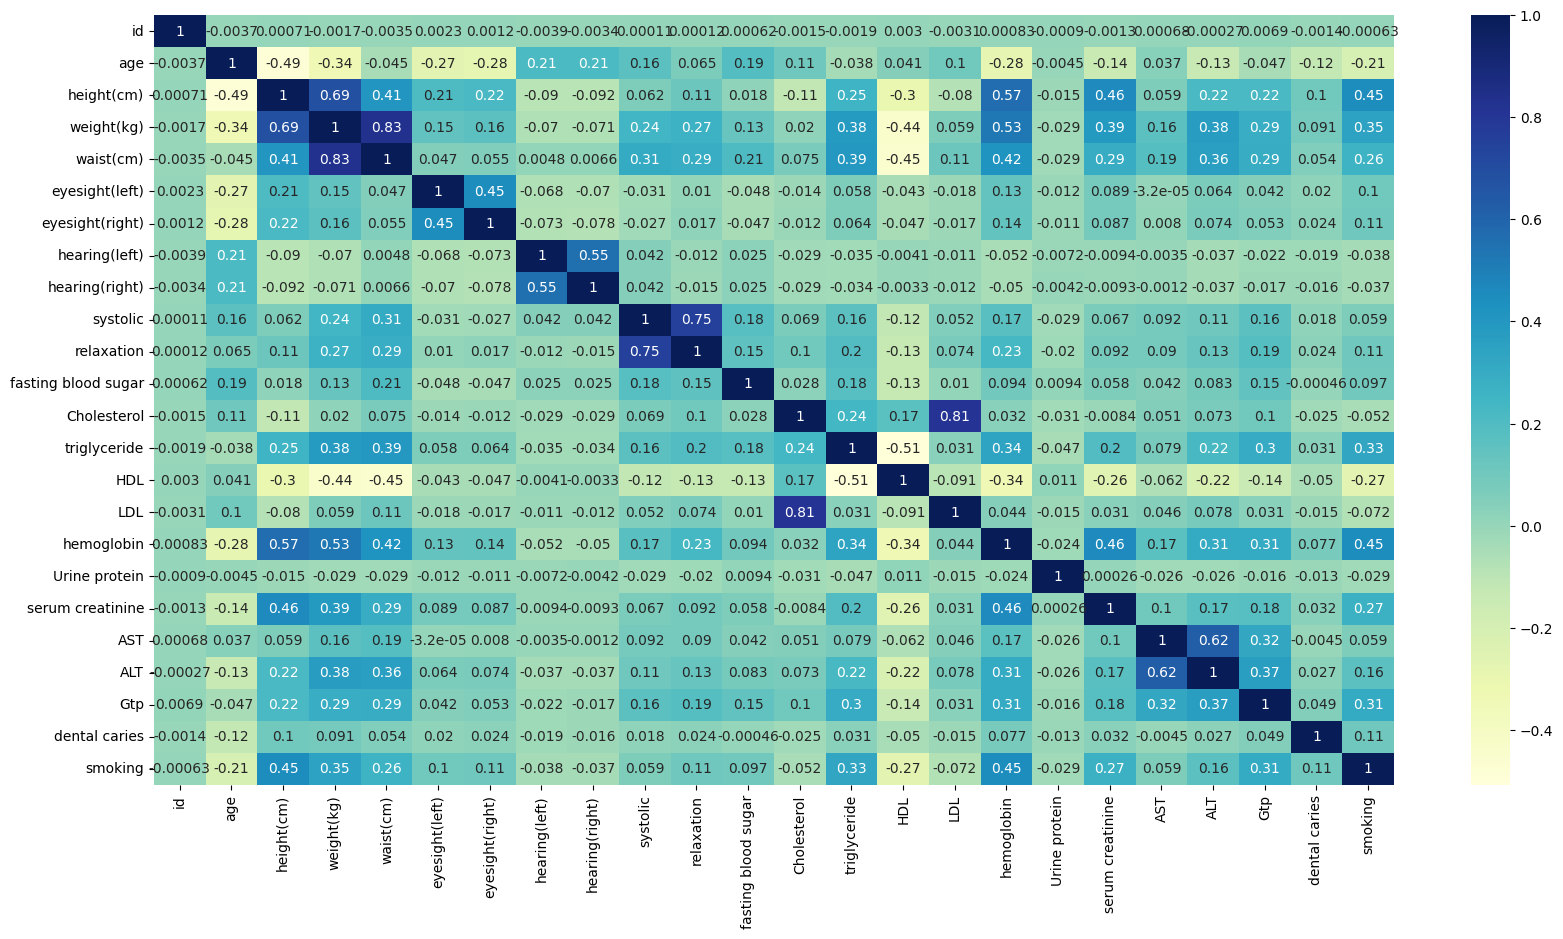

In [ ]:
#correlation check
#Checking for multicollinearity
plt.figure(figsize= (20,10))
sns.heatmap(df.corr(),cmap="YlGnBu",annot=True);

In [ ]:
#Outlier detection
df.describe(percentiles=[0.25,0.50,0.75,0.90,0.95,0.99])

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,...,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,...,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
90%,143329.500000,60.000000,175.000000,85.000000,94.200000,1.500000,1.500000,1.000000,1.000000,139.000000,...,76.000000,148.000000,16.500000,1.000000,1.100000,36.000000,46.000000,66.000000,1.000000,1.000000
95%,151292.250000,65.000000,180.000000,90.000000,98.000000,1.500000,1.500000,1.000000,1.000000,144.000000,...,83.000000,157.000000,16.800000,2.000000,1.200000,41.000000,55.000000,88.000000,1.000000,1.000000
99%,157662.450000,75.000000,185.000000,100.000000,104.000000,1.500000,1.500000,2.000000,2.000000,154.000000,...,94.000000,174.000000,17.600000,3.000000,1.300000,54.000000,81.000000,152.000000,1.000000,1.000000


In [ ]:
#Skewness check
skew = df.skew(axis = 0,skipna = True)
skewdf = pd.DataFrame(skew).reset_index()
skewdf.columns = ['Features','skew']
skewdf

,Features,skew
0,id,0.000000
1,age,0.291697
2,height(cm),-0.269915
3,weight(kg),0.378075
4,waist(cm),0.072446
5,eyesight(left),8.890572
6,eyesight(right),8.486849
7,hearing(left),6.223920
8,hearing(right),6.302437
9,systolic,0.219925


In [ ]:
#variables which are skewed and need treatment
skewdf = skewdf[(skewdf['skew']>3) | (skewdf['skew'] <-3)]
skewdf

,Features,skew
5,eyesight(left),8.890572
6,eyesight(right),8.486849
7,hearing(left),6.223920
8,hearing(right),6.302437
11,fasting blood sugar,3.461099
15,LDL,6.874810
17,Urine protein,5.585562
19,AST,11.592346
20,ALT,34.830012
21,Gtp,5.414827


In [ ]:
skewlst = skewdf['Features'].to_list()
skewlst

['eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'fasting blood sugar',
 'LDL',
 'Urine protein',
 'AST',
 'ALT',
 'Gtp']

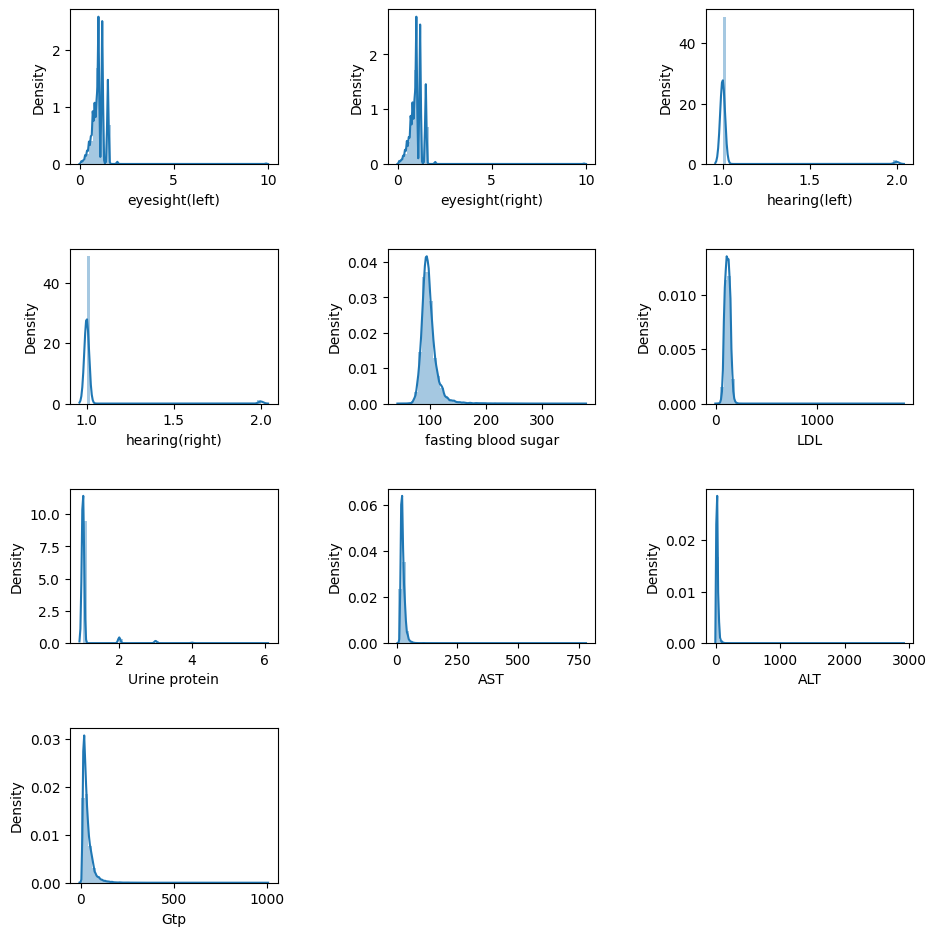

In [ ]:
# plot the histogram of a variable from the dataset to see the skewness
# plotting distplot to view left/right skewness in skewed columns
plt.figure(figsize=(10,10))
plt.tight_layout(pad=3.0)


for i in range(len(skewlst)):
  plt.subplot(4,3,i+1)
  sns.distplot(df[skewlst[i]],kde = True)
  plt.tight_layout(pad=3.0)

Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood.

Box-Cox requires input data to be strictly positive, while Yeo-Johnson supports both positive or negative data.

Looks no outliers

In [ ]:
#train-test split
X = df.drop(['id','smoking'],axis =1)
y = df['smoking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state= 42, stratify= y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((111479, 22), (47777, 22), (111479,), (47777,))

In [ ]:
#skeness mitigation on train data to make it more Gaussian
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method = 'yeo-johnson',standardize=True)
X_train = pt.fit_transform(X_train)

In [ ]:
#skeness mitigation on test data to make it more Gaussian
X_test = pt.fit_transform(X_test)

In [ ]:
#Feature scaling
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
y_train.shape

(111479,)

In [ ]:
y_train_pred = y_train_pred.reshape(-1,)

## Random forest

In [ ]:
rf = RandomForestClassifier()
model1 = rf.fit(X_train_scaled,y_train)
y_train_pred = model1.predict_proba(X_train_scaled)[:,1] # making it 1d with [:,-1]
y_test_pred = model1.predict_proba(X_test_scaled)[:,1]

In [ ]:
y_train_pred.shape

(111479,)

In [ ]:
y_test_pred.shape

(47777,)

In [ ]:
X_test_scaled.shape

(47777, 22)

In [ ]:
X_train_scaled.shape

(111479, 22)

In [ ]:
print('roc_auc_score(Random Forest)_train: ',roc_auc_score(y_train, y_train_pred))
print('roc_auc_score(Random Forest)_test: ',roc_auc_score(y_test, y_test_pred))

roc_auc_score(Random Forest)_train:  1.0
roc_auc_score(Random Forest)_test:  0.8548192843003876


## Random forest Hyperperameter tuning

In [ ]:
params = {
    'n_estimators' : [50,80,100,150,200],
    'max_depth' : [3,5,7],
    'min_samples_split':[4,6,8],
    'min_samples_leaf':[4,6],
    'max_features':['log2','sqrt']
}
rfhyper = RandomForestClassifier()
gridsearch = GridSearchCV(estimator=rfhyper,param_grid= params,n_jobs=-1,scoring='roc_auc')
model4 = gridsearch.fit(X_train_scaled,y_train)
y_train_pred = model4.predict_proba(X_train_scaled)[:,1]
y_test_pred = model4.predict_proba(X_test_scaled)[:,1]

print('roc_auc_score(rf hyper)_train: ',roc_auc_score(y_train, y_train_pred))
print('roc_auc_score(rf hyper)_test: ',roc_auc_score(y_test, y_test_pred))

roc_auc_score(rf hyper)_train:  0.8505930951963632
roc_auc_score(rf hyper)_test:  0.8432776011031092


## XGBoost

In [ ]:
xgb = XGBClassifier()
model2 = xgb.fit(X_train_scaled,y_train)
#y_train_pred = model2.predict(X_train_scaled)
#y_test_pred = model2.predict(X_test_scaled)

y_train_pred = model2.predict_proba(X_train_scaled)[:,1]
y_test_pred = model2.predict_proba(X_test_scaled)[:,1]

print('roc_auc_score(XGBoost)_train: ',roc_auc_score(y_train, y_train_pred))
print('roc_auc_score(XGBoost)_test: ',roc_auc_score(y_test, y_test_pred))

roc_auc_score(XGBoost)_train:  0.9077563205504917
roc_auc_score(XGBoost)_test:  0.8538254020556143


roc_auc_score(XGBoost)_train:  0.8263241382058966
roc_auc_score(XGBoost)_test:  0.7807184544375805

In [ ]:
#hyper parameter tuning for XGBoost-1st time
params = {
    'n_estimators' : [5,10,20,50,75,100,200],
    'max_depth'    : [4,6,8,10],
    'learning_rate' : [0.1,0.2]

}

grid_search = GridSearchCV(estimator=model2,param_grid=params, n_jobs= -1,cv=5,scoring= 'roc_auc',error_score=0)
model3 = grid_search.fit(X_train_scaled,y_train)
y_train_pred = model3.predict_proba(X_train_scaled)[:,1]
y_test_pred = model3.predict_proba(X_test_scaled)[:,1]

print('roc_auc_score(XGBoost_hyper)_train: ',roc_auc_score(y_train, y_train_pred))
print('roc_auc_score(XGBoost_hyper)_test: ',roc_auc_score(y_test, y_test_pred))

roc_auc_score(XGBoost_hyper)_train:  0.8840030802300136
roc_auc_score(XGBoost_hyper)_test:  0.8560573488262287


In [ ]:
#hyper parameter tuning for XGBoost-2nd time
params = {
    'n_estimators' : [350,400,500],
    'max_depth'    : [4],
    'learning_rate' : [0.2],


}

grid_search = GridSearchCV(estimator=model2,param_grid=params, n_jobs= -1,cv=5,scoring= 'roc_auc',error_score=0)
model3_next = grid_search.fit(X_train_scaled,y_train)
y_train_pred = model3_next.predict_proba(X_train_scaled)[:,1]
y_test_pred = model3_next.predict_proba(X_test_scaled)[:,1]

print('roc_auc_score(XGBoost_hyper)_train: ',roc_auc_score(y_train, y_train_pred))
print('roc_auc_score(XGBoost_hyper)_test: ',roc_auc_score(y_test, y_test_pred))

roc_auc_score(XGBoost_hyper)_train:  0.8982250432561945
roc_auc_score(XGBoost_hyper)_test:  0.8563154503260441


In [ ]:
print('Best_estimator_',model3_next.best_estimator_)
print('Best_parameters',model3_next.best_params_)

Best_estimator_ XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best_parameters {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 400}


# Test

In [ ]:
test.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'],
      dtype='object')

In [ ]:
test_copy = test.copy()

In [ ]:
test = test.drop(['id'],axis =1)

In [ ]:
#Power transformation on actual test data for submission
test = pt.fit_transform(test)

In [ ]:
x_test_scaled_submi = sc.transform(test)

In [ ]:
y_test_submission = model3_next.predict_proba(x_test_scaled_submi)

In [ ]:
y_test_submission.shape

(106171, 2)

In [ ]:
y_test_submission

array([[0.4585703 , 0.5414297 ],
       [0.3617912 , 0.6382088 ],
       [0.65409446, 0.34590554],
       ...,
       [0.6870334 , 0.31296661],
       [0.9315875 , 0.06841248],
       [0.939872  , 0.06012795]], dtype=float32)

In [ ]:
#submission data
submission = pd.DataFrame({'id':test_copy['id'],'smoking':y_test_submission[:,1]})

In [ ]:
submission.to_csv('submission.csv',index = False)

In [ ]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Tabular Playground Series/Binary Prediction of Smoker Status using Bio-Signals'